### New Orleans Short-Term Rental Applications

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("Short-Term_Rental_Permit_Applications.csv")
print(f"Number of rows: {len(df)}")
display(df.head())

Number of rows: 24019


,Permit Number,Address,Permit Type,Residential Subtype,Current Status,Expired,Expiration Date,Bedroom Limit,Guest Occupancy Limit,Link,...,Operator Phone,Operator Email,Operator Permit Number,License Holder Name,Application Date,Issue_Date,Reference Code,X,Y,Location
0,NaN,NaN,NaN,NaN,Duplicate,Yes,NaN,NaN,NaN,http://onestopapp.nola.gov/Redirect.aspx?Searc...,...,NaN,NaN,NaN,Curtis Alex,03/14/2017,NaN,YZ1BXS,-1.000000e+00,-1.00000,"(28.09889070681073, -101.51779913517812)"
1,NaN,932 N Rendon ST,Temporary STR,NaN,Denied,Yes,NaN,NaN,NaN,http://onestopapp.nola.gov/Redirect.aspx?Searc...,...,NaN,NaN,NaN,Karen Brandao,04/04/2017,NaN,TSMLQC,3.675644e+06,539075.76615,"(29.976447982920885, -90.08630146205046)"
2,NaN,814 Third ST,Accessory STR,NaN,Denied,Yes,NaN,NaN,NaN,http://onestopapp.nola.gov/Redirect.aspx?Searc...,...,NaN,NaN,NaN,Ian Willson,04/04/2017,NaN,VK2DRT,3.678036e+06,520322.66962,"(29.92481143736287, -90.079394480006)"
3,NaN,527 Napoleon Ave,Temporary STR,NaN,Denied,Yes,NaN,NaN,NaN,http://onestopapp.nola.gov/Redirect.aspx?Searc...,...,NaN,NaN,NaN,Brett Marcel Babineaux,04/11/2017,NaN,KA3FY7,3.671252e+06,517639.72869,"(29.91763659810659, -90.10090070967331)"
4,NaN,5821 Carlisle CT,Accessory STR,NaN,Withdrawn,Yes,NaN,NaN,NaN,http://onestopapp.nola.gov/Redirect.aspx?Searc...,...,NaN,NaN,NaN,Jean Ann Rolla,04/28/2017,NaN,D6DMUD,3.705188e+06,516473.22111,"(29.913381859718466, -89.99382935360973)"


In [3]:
# remove duplicates as they add no new info
df = df.drop(df.loc[df["Current Status"] == "Duplicate"].index)
print(f"Number of rows: {len(df)}")

Number of rows: 22796


In [4]:
num_add_missing = len(df.loc[df["Address"].isnull() == True].index)
print(f"There are {num_add_missing} addresses missing.")
num_loc_missing = len(df.loc[df["Location"].isnull() == True].index)
print(f"There are {num_loc_missing} locations missing.")
num_app_missing = len(df.loc[df["Application Date"].isnull() == True].index)
print(f"There are {num_app_missing} application dates missing.")

There are 228 addresses missing.
There are 0 locations missing.
There are 32 application dates missing.


There are 228 rows where there is no address, but there is a location coordinate for each address. Should I keep or discard?

Because there's only 32 rows with missing application dates, I will drop those and use application date to keep only the most recent application for each location coordinate.

In [11]:
# drop rows with missing application date
df = df.drop(df.loc[df["Application Date"].isnull()].index)
df["Application Date"] = pd.to_datetime(df["Application Date"])
df["Year"] = pd.DatetimeIndex(df["Application Date"]).year

df_last_loc = df.sort_values("Application Date").drop_duplicates("Location", keep="last")

print(len(df_last_loc))
print(df["Address"].nunique())


14423
12687


After futher inspection, it seems that different locations have the same address, so it may be best to use Address as a unique id rather than Location.

For looking at the counts of "Current Status" I want to only have the last entry for each unique address, so I will remove duplicate addresses for that graph.

Text(0.5, 1.0, 'Current Status of Last Submitted Application for Each Address')

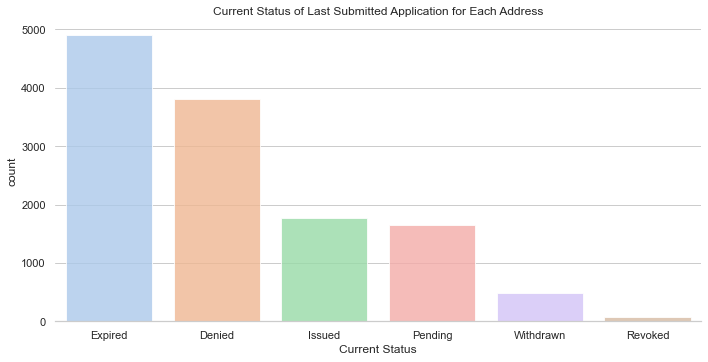

In [12]:
df_last_add = df.sort_values("Application Date").drop_duplicates("Address", keep="last")
df_last_add = df_last_add.drop(df_last_add[df_last_add["Address"].isnull()].index)

sns.set_theme(style="whitegrid", palette="pastel")

g = sns.catplot(x="Current Status", data=df_last_add, kind="count", alpha=0.8,
                    height=5, aspect=2, order=["Expired","Denied","Issued","Pending","Withdrawn","Revoked"])
g.despine(left=True)
plt.title("Current Status of Last Submitted Application for Each Address")

In [13]:
issued_num = df_last_add.groupby("Current Status")["Application Date"].count()["Issued"]
print(f"There are currently {issued_num} issued short-term rental permits.")

There are currently 1770 issued short-term rental permits.


It's not too surprising that the majority of the most recent applications for short-term rentals in New Orleans are either expired or denied as most people have not been traveling due to COVID.

We can see this clearly when looking at the number of applications by year. 

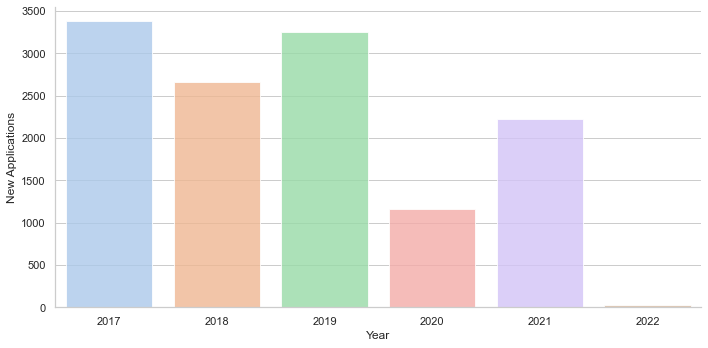

In [14]:
g = sns.catplot(x="Year", data=df_last_add, alpha=0.8, kind="count", height=5, aspect=2)
g.set_ylabels("New Applications")

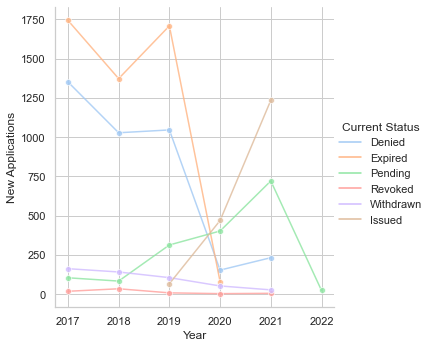

In [15]:
df_year_status = df_last_add.groupby(["Year","Current Status"])["Application Date"].count().reset_index()

g = sns.relplot(x="Year",  y="Application Date", hue="Current Status", data=df_year_status, alpha=0.8, 
                kind="line", marker="o", height=5)
g.set_ylabels("New Applications")

Another question: Which addresses have had the most applications put in?

Text(0.5, 0, 'Applications')

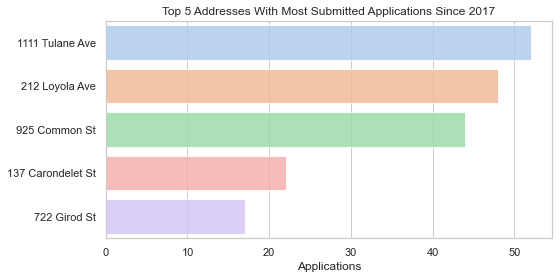

In [ ]:
# top 5 addresses that have the most applications
top_5_adds = df.groupby("Address")["Application Date"].count().sort_values(ascending=False).head(5)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=top_5_adds.values, y=top_5_adds.index, ax=ax, alpha=0.8)
ax.set_title("Top 5 Addresses With Most Submitted Applications Since 2017")
ax.set_ylabel("")
ax.set_xlabel("Applications")

In [19]:
df_year_count = df_last_add.groupby("Year")["Application Date"].count().reset_index()
df_year_count.rename(columns={"Year":"Year","Application Date":"Application Count"}, inplace=True)

In [20]:
df_year_count

,Year,Application Count
0,2017,3380
1,2018,2659
2,2019,3247
3,2020,1158
4,2021,2220
5,2022,23
